# Predict income

* **Business Context**: Prediction task is to determine whether a person makes over 50K a year based. 
* **Associated tasks**: Classification. 

* **Dataset**: The dataset is taken from UCI machine learning repository https://archive.ics.uci.edu/ml/datasets/Adult . The number of instances is 48842. 
* **Attributes**: Multivariate categorical and Integer
 
    * class : >50K, <=50K
    * age: continuous.
    * workclass: Private, Self-emp-not-inc, Self-emp-inc, Federal-gov, Local-gov, State-gov, Without-pay, Never-worked.
    * fnlwgt: continuous.
    * education: Bachelors, Some-college, 11th, HS-grad, Prof-school, Assoc-acdm, Assoc-voc, 9th, 7th-8th, 12th, Masters, 1st-4th, 10th, Doctorate, 5th-6th, Preschool.
    * education-num: continuous.
    * marital-status: Married-civ-spouse, Divorced, Never-married, Separated, Widowed, Married-spouse-absent, Married-AF-spouse.
    * occupation: Tech-support, Craft-repair, Other-service, Sales, Exec-managerial, Prof-specialty, Handlers-cleaners, Machine-op-inspct, Adm-clerical, Farming-fishing, Transport-moving, Priv-house-serv, Protective-serv, Armed-Forces.
    * relationship: Wife, Own-child, Husband, Not-in-family, Other-relative, Unmarried.
    * race: White, Asian-Pac-Islander, Amer-Indian-Eskimo, Other, Black.
    * sex: Female, Male.
    * capital-gain: continuous.
    * capital-loss: continuous.
    * hours-per-week: continuous.
    * native-country: United-States, Cambodia, England, Puerto-Rico, Canada, Germany, Outlying-US(Guam-USVI-etc), India, Japan, Greece, South, China, Cuba, Iran, Honduras, Philippines, Italy, Poland, Jamaica, Vietnam, Mexico, Portugal, Ireland, France, Dominican-Republic, Laos, Ecuador, Taiwan, Haiti, Columbia, Hungary, Guatemala, Nicaragua, Scotland, Thailand, Yugoslavia, El-Salvador, Trinadad&Tobago, Peru, Hong, Holand-Netherlands.>50K, <=50K.
* Missing values are represented by '?'

In [370]:
!pip -q install keras
!pip -q install imblearn
!pip -q install xgboost
!pip -q install lightgbm
!pip -q install shap
!pip -q install lime

In [428]:
#Loading the necessary libraries and setting them up

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import pickle
import warnings
import tensorflow as tf
import keras
import keras.backend as K
import shap

from scipy.stats import kurtosis
from scipy import stats, special
from scipy.stats import skew, tstd

from lime.lime_tabular import LimeTabularExplainer

from sklearn.impute import SimpleImputer
from sklearn import preprocessing
from sklearn.feature_selection import VarianceThreshold, chi2
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import mean_squared_error, accuracy_score,confusion_matrix, roc_curve, auc,classification_report, recall_score, precision_score, f1_score,roc_auc_score,auc,roc_curve
from sklearn.ensemble import RandomForestClassifier,GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import MinMaxScaler

from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras import models
from keras import layers

from imblearn.over_sampling import SMOTE

from xgboost import XGBClassifier

from lightgbm import LGBMClassifier

from IPython.core.interactiveshell import InteractiveShell

In [372]:
# Setting libraries up

warnings.filterwarnings('ignore')
warnings.filterwarnings(action='ignore')
InteractiveShell.ast_node_interactivity = "all"

## Exploratory Data Analysis (EDA)

In [373]:
# Load Dataset

COLUMNS =  ['age', 'workclass', 'fnlwgt', 'education', 'education-num', 'marital-status', 'occupation', 'relationship',
            'race', 'sex', 'capital-gain', 'capital-loss', 'hours-per-week', 'native-country', 'class' ]

URL = 'https://archive.ics.uci.edu/ml/machine-learning-databases/adult/adult.data'

df = pd.read_csv(URL, header=None, names=COLUMNS)
df.head()

,age,workclass,fnlwgt,education,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country,class
0,39,State-gov,77516,Bachelors,13,Never-married,Adm-clerical,Not-in-family,White,Male,2174,0,40,United-States,<=50K
1,50,Self-emp-not-inc,83311,Bachelors,13,Married-civ-spouse,Exec-managerial,Husband,White,Male,0,0,13,United-States,<=50K
2,38,Private,215646,HS-grad,9,Divorced,Handlers-cleaners,Not-in-family,White,Male,0,0,40,United-States,<=50K
3,53,Private,234721,11th,7,Married-civ-spouse,Handlers-cleaners,Husband,Black,Male,0,0,40,United-States,<=50K
4,28,Private,338409,Bachelors,13,Married-civ-spouse,Prof-specialty,Wife,Black,Female,0,0,40,Cuba,<=50K


In [374]:
df.describe()

,age,fnlwgt,education-num,capital-gain,capital-loss,hours-per-week
count,32561.000000,3.256100e+04,32561.000000,32561.000000,32561.000000,32561.000000
mean,38.581647,1.897784e+05,10.080679,1077.648844,87.303830,40.437456
std,13.640433,1.055500e+05,2.572720,7385.292085,402.960219,12.347429
min,17.000000,1.228500e+04,1.000000,0.000000,0.000000,1.000000
25%,28.000000,1.178270e+05,9.000000,0.000000,0.000000,40.000000
50%,37.000000,1.783560e+05,10.000000,0.000000,0.000000,40.000000
75%,48.000000,2.370510e+05,12.000000,0.000000,0.000000,45.000000
max,90.000000,1.484705e+06,16.000000,99999.000000,4356.000000,99.000000


In [375]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 32561 entries, 0 to 32560
Data columns (total 15 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   age             32561 non-null  int64 
 1   workclass       32561 non-null  object
 2   fnlwgt          32561 non-null  int64 
 3   education       32561 non-null  object
 4   education-num   32561 non-null  int64 
 5   marital-status  32561 non-null  object
 6   occupation      32561 non-null  object
 7   relationship    32561 non-null  object
 8   race            32561 non-null  object
 9   sex             32561 non-null  object
 10  capital-gain    32561 non-null  int64 
 11  capital-loss    32561 non-null  int64 
 12  hours-per-week  32561 non-null  int64 
 13  native-country  32561 non-null  object
 14  class           32561 non-null  object
dtypes: int64(6), object(9)
memory usage: 3.7+ MB


## Feature understanding

#### Univariate visualisation

In [376]:
# Missing values are represented by '?'.  They might be present in object type columns
train_data = df.replace('(^\s+|\s+$)', '', regex=True)
train_data = train_data.replace('^\?{1}', np.nan, regex=True)

In [377]:
data_count = train_data['workclass'].value_counts().head()

In [378]:
def plot_nominal_columns(df, columns):
    for column in columns:        
        data = df[df[column].isnull() == False]
        data_count = data[column].value_counts().head()
        labels = data_count.keys()
        fig, ax = plt.subplots(figsize=(10,6))
        ax.set_title(column + ' Percentile')
        ax  = plt.pie(x=data_count, autopct="%.1f%%", labels=labels, pctdistance=0.5) 
        print("---- " + column + " ----")
        print ('Null(%): ' + str(round(df[column].isnull().sum()/len(df)*100)))
        print (f'Mode: {df[column].mode()[0]}')
        plt.show()        

---- workclass ----
Null(%): 6
Mode: Private


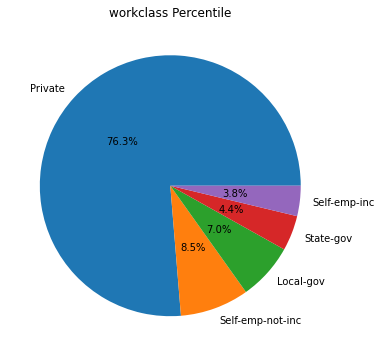

---- education ----
Null(%): 0
Mode: HS-grad


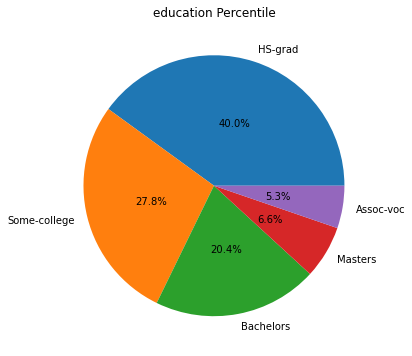

---- marital-status ----
Null(%): 0
Mode: Married-civ-spouse


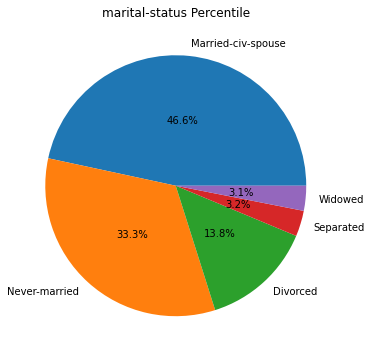

---- occupation ----
Null(%): 6
Mode: Prof-specialty


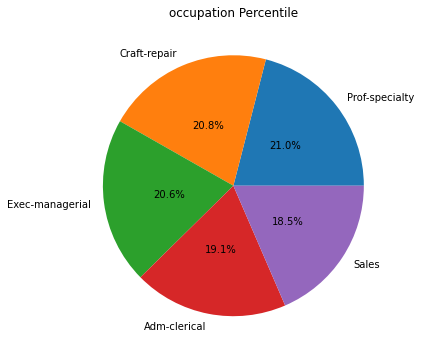

---- relationship ----
Null(%): 0
Mode: Husband


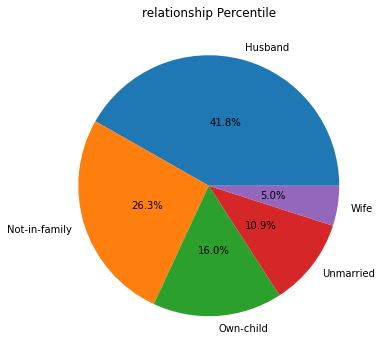

---- race ----
Null(%): 0
Mode: White


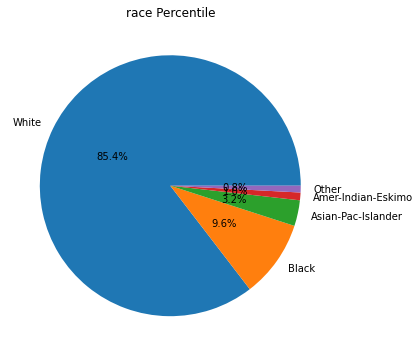

---- sex ----
Null(%): 0
Mode: Male


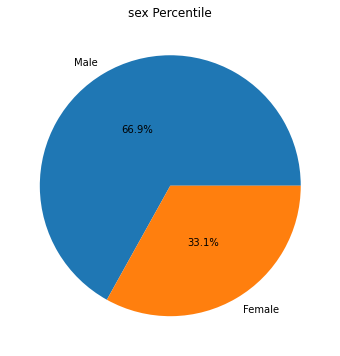

---- native-country ----
Null(%): 2
Mode: United-States


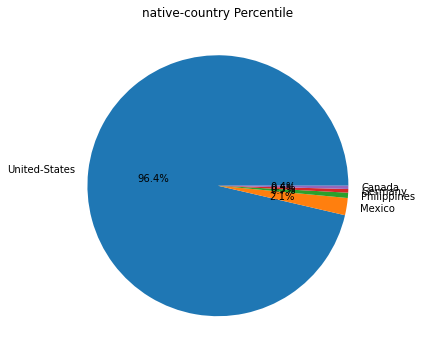

In [379]:
#describe data for Nominal data

nominal_columns = ['workclass', 'education', 'marital-status', 'occupation', 'relationship', 'race', 'sex', 'native-country']
plot_nominal_columns(train_data, nominal_columns)

* **Key takeaways:**
* **
    * workclass : Null value to be handled
    * occupation : Null value to be handled
    * native-country : Null value to be handled
    
* **   

In [380]:
def plot_ordinal_columns(df, columns):
    for column in columns:        
        data = df[df[column].isnull() == False]
        data_count = data[column].value_counts()
        labels = data_count.keys()
        fig, ax = plt.subplots(figsize=(10,6))   
        ax.grid(False)
        ax.set_title(column + ' Stem')
        ax  = plt.stem(labels, data_count.values) 
        print("---- " + column + " ----")
        print ('Null(%): ' + str(round(df[column].isnull().sum()/len(df)*100)))        
        print (f'Mode: {df[column].mode()[0]}')
        print (f'Median: {df[column].median()}')
        plt.show()

---- age ----
Null(%): 0
Mode: 36
Median: 37.0


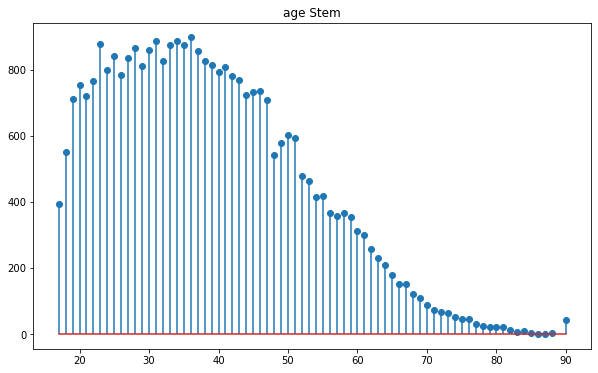

---- education-num ----
Null(%): 0
Mode: 9
Median: 10.0


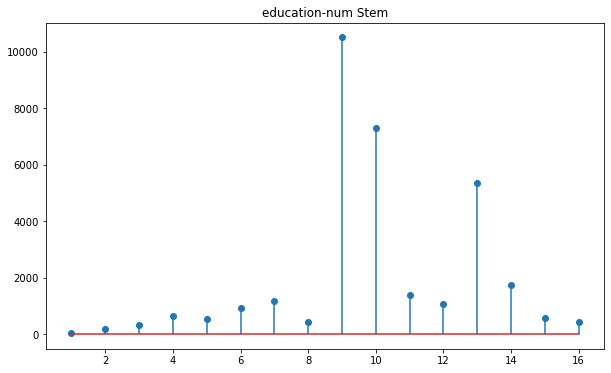

In [381]:
# Ordinal values and describe
ordinal_columns = ['age', 'education-num']

plot_ordinal_columns(train_data, ordinal_columns)

In [382]:
def plot_ratio_hist_boxplot(df, columns):
    for column in columns:      
        fig,[ax1,ax2]=plt.subplots(1,2,figsize=(12,5))
        ax1.grid(False)
        ax2.grid(False)
        sns.distplot(df[df[column].notnull()][column],ax=ax1)
        sns.boxplot(y=df[df[column].notnull()][column],ax=ax2)
        print("---- " + column + " ----")
        print("skewness : ",skew(df[df[column].notnull()][column]))
        print("kurtosis : ",kurtosis(df[df[column].notnull()][column]))
        print("standard : ",tstd(df[df[column].notnull()][column]))
        plt.show()

In [383]:
def plot_ratio_count_boxplot(df, columns):
    for column in columns:
        fig,[ax1,ax2]=plt.subplots(1,2,figsize=(12,6))
        ax1.grid(False)
        ax2.grid(False)
        sns.countplot(df[df[column].notnull()][column],ax=ax1)
        sns.boxplot(y=df[train_data[column].notnull()][column],ax=ax2)
        print("---- " + column + " ----")
        print("skewness : ",skew(df[df[column].notnull()][column]))
        print("kurtosis : ",kurtosis(df[df[column].notnull()][column]))
        print("standard : ",tstd(df[df[column].notnull()][column]))
        plt.show()

In [384]:
#plot continuous(ratio) column

ratio_columns = ['fnlwgt', 'capital-gain', 'capital-loss', 'hours-per-week']

---- fnlwgt ----
skewness :  1.446913435142329
kurtosis :  6.217671807559244
standard :  105549.97769702224


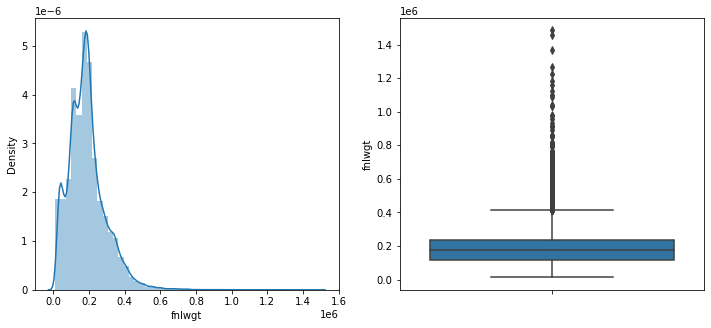

---- capital-gain ----
skewness :  11.953296998194332
kurtosis :  154.7754839300255
standard :  7385.292084840338


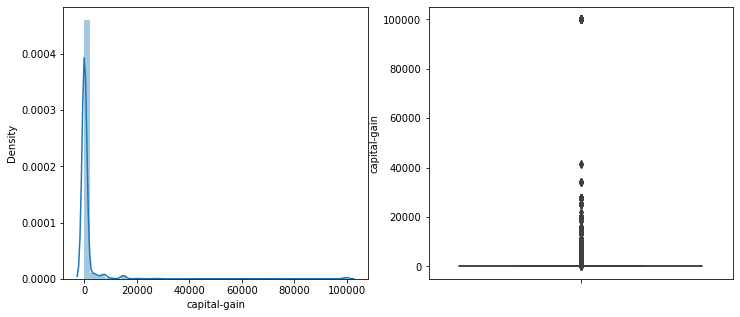

---- capital-loss ----
skewness :  4.59441745643977
kurtosis :  20.373488564437295
standard :  402.9602186489998


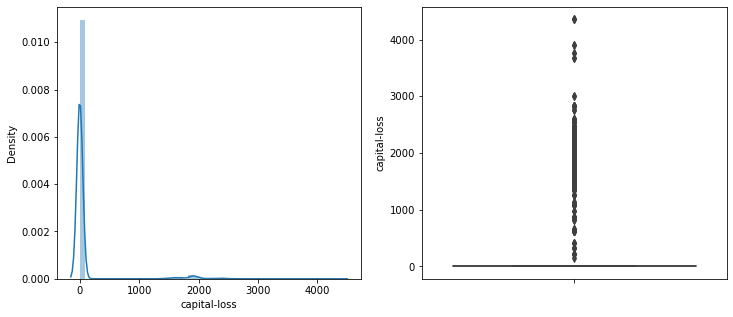

---- hours-per-week ----
skewness :  0.227632049774777
kurtosis :  2.9160546709844883
standard :  12.347428681731843


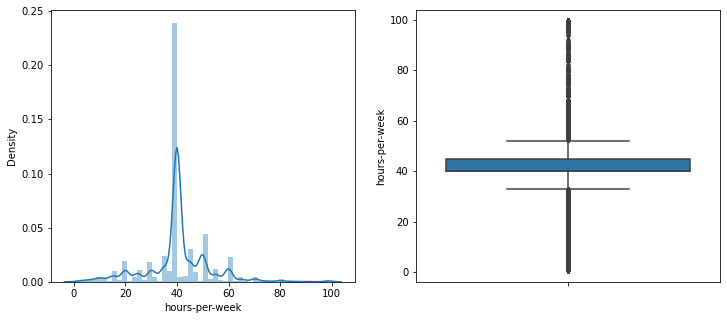

In [385]:
plot_ratio_hist_boxplot(train_data, ratio_columns)

* **Key takeaways:**
* **
    * fnlwgt : non-normal data
    * capital-gain : non-normal data
    
* **   

## Feature Improvement

In [386]:
categorical_columns = ['workclass', 'education', 'marital-status', 'occupation', 'relationship','race', 'sex','native-country']
continuous_columns = ['age', 'fnlwgt', 'education-num', 'capital-gain', 'capital-loss', 'hours-per-week']

#### Handling missing values

In [387]:
def MissingHandler(df):    
    DataMissing = df.isnull().sum()*100/len(df)
    DataMissingByColumn = pd.DataFrame({'Percentage Nulls':DataMissing})
    DataMissingByColumn.sort_values(by='Percentage Nulls',ascending=False,inplace=True)
    return DataMissingByColumn[DataMissingByColumn['Percentage Nulls']>0]

In [388]:
MissingHandler(train_data)

,Percentage Nulls
occupation,5.660146
workclass,5.638647
native-country,1.790486


In [389]:
class Data_preprocessing_handling:
    def __init__(self,train_data):
        self.train_data = train_data
    
    def handle_missing_value_continuous(self,column_names_with_specific_type,imputation_type="mean"):
        if imputation_type=="mean":
            mean_imputer = SimpleImputer(missing_values=np.nan, strategy='mean')
            mean_imputer.fit(self.train_data[column_names_with_specific_type])
            self.train_data[column_names_with_specific_type]=mean_imputer.transform(self.train_data[column_names_with_specific_type])
        if imputation_type=="median":
            median_imputer = SimpleImputer(missing_values=np.nan, strategy='median')
            median_imputer.fit(self.train_data[column_names_with_specific_type])
            self.train_data[column_names_with_specific_type]=median_imputer.transform(self.train_data[column_names_with_specific_type])
        return self.train_data
    
    def handle_missing_value_categorical(self,column_names_with_specific_type,imputation_type="most_frequent"):
        most_frequent = SimpleImputer(strategy="most_frequent")
        most_frequent.fit(self.train_data[column_names_with_specific_type])
        self.train_data[column_names_with_specific_type] = most_frequent.transform(train_data[column_names_with_specific_type])
        return self.train_data
    
    def handle_outlier_treatment(self,Q1,Q3,IQR,columns_with_outlier,action):
        if action=="median":
            for i in range(len(columns_with_outlier)):
                column_name = columns_with_outlier[i]
                meadian_outlier = np.median(self.train_data[column_name])
                self.train_data.loc[self.train_data[((self.train_data[column_name]<(Q1[column_name]-(1.5*IQR[column_name])))|(self.train_data[column_name]>(Q3[column_name]+(1.5*IQR[column_name]))))].index,column_name]=meadian_outlier
        if action=="mean":
            for i in range(len(columns_with_outlier)):
                column_name = columns_with_outlier[i]
                mean_outlier = np.mean(self.train_data[column_name])
                self.train_data.loc[self.train_data[((self.train_data[column_name]<(Q1[column_name]-(1.5*IQR[column_name])))|(self.train_data[column_name]>(Q3[column_name]+(1.5*IQR[column_name]))))].index,column_name]=mean_outlier
        if action=="remove":
            for i in range(len(columns_with_outlier)):
                column_name = columns_with_outlier[i]
                self.train_data = self.train_data[~((self.train_data[column_name]<(Q1[column_name]-(1.5*IQR[column_name])))|(self.train_data[column_name]>(Q3[column_name]+(1.5*IQR[column_name]))))]
        return self.train_data

In [390]:
missing_categorical_columns = ['workclass', 'occupation', 'native-country']

In [391]:
Data_preprocessing_obj = Data_preprocessing_handling(train_data)
train_data = Data_preprocessing_obj.handle_missing_value_categorical(missing_categorical_columns)

In [392]:
#Check if there is any missing value in the columuns
#value of 0 indicates no missing values
missing_values = train_data.isnull().sum()
np.max(missing_values)

0

#### Feature scaling

In [403]:
#checking for outliers

skewness  = [] ; kurt = []
for column in continuous_columns:
    skewness.append(skew(train_data[train_data[column].notnull()][column]))
    kurt.append(kurtosis(train_data[train_data[column].notnull()][column]))
    
stats = pd.DataFrame({'Skewness' : skewness, 'Kurtosis' : kurt},index=[col for col in continuous_columns])
stats.sort_values(by=['Skewness'], ascending=False)

,Skewness,Kurtosis
age,0.558718,-0.166286
fnlwgt,0.419184,-0.141071
hours-per-week,0.227632,2.916055
capital-gain,0.000000,-3.000000
capital-loss,0.000000,-3.000000
education-num,-0.311662,0.623164


** No significant outlier so we will do a regular normalisation instead of standardisation

## Feature Selection

** The whole purpose of the feature selection is to improve the accuracy of the model and also to reduce the time cost. There are 2 umbrellas of feature selection : statistical-based and model-based. Statistical-based relies on statistical tests like IQR, chi2/p-values, correlation test,etc... and it is done prior to modeling step.  Model-based consists of preprocessing model which will allow to assess the relevance of each feature before running the definitive model with less feature. Here, we will use statistical-based approach

In [404]:
#Function for feature selection of numeric variables
#Remove variables with constant variance
#Remove variables with Quasi-Constant variance with a fixed threshold
#Remove correlated variables

def feature_selection_numerical_variables(train_data,qthreshold,corr_threshold,exclude_numerical_cols_list):
    num_colums = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']
    numerical_columns = list(train_data.select_dtypes(include=num_colums).columns)
    numerical_columns = [column for column in numerical_columns if column not in exclude_numerical_cols_list]
    
    #remove variables with constant variance
    constant_filter = VarianceThreshold(threshold=0)
    constant_filter.fit(train_data[numerical_columns])
    constant_columns = [column for column in train_data[numerical_columns].columns 
                    if column not in train_data[numerical_columns].columns[constant_filter.get_support()]]
    if len(constant_columns)>0:
        train_data.drop(labels=constant_columns, axis=1, inplace=True)

    #remove deleted columns from dataframe
    numerical_columns = [column for column in numerical_columns if column not in constant_columns]
        
    #remove variables with qconstant variance
    #Remove quasi-constant variables
    qconstant_filter = VarianceThreshold(threshold=qthreshold)
    qconstant_filter.fit(train_data[numerical_columns])
    qconstant_columns = [column for column in train_data[numerical_columns].columns 
                         if column not in train_data[numerical_columns].columns[qconstant_filter.get_support()]]
    if len(qconstant_columns)>0:
        train_data.drop(labels=qconstant_columns, axis=1, inplace=True)
    
    #remove deleted columns from dataframe
    numerical_columns = [column for column in numerical_columns if column not in qconstant_columns]
    
    #remove correlated variables
    correlated_features = set()
    correlation_matrix = train_data[numerical_columns].corr()
    ax = sns.heatmap(
    correlation_matrix, annot=True, 
    vmin=-1, vmax=1, center=0,
    cmap=plt.cm.CMRmap_r)
    ax.set_xticklabels(
        ax.get_xticklabels(),
        rotation=45,
        horizontalalignment='right');
    #print(correlation_matrix)
    
    for i in range(len(correlation_matrix.columns)):
        for j in range(i):
            if abs(correlation_matrix.iloc[i, j]) > corr_threshold:
                colname = correlation_matrix.columns[i]
                colcompared = correlation_matrix.columns[j]
                #check if the column compared against is not in the columns excluded list
                if colcompared not in correlated_features:
                    correlated_features.add(colname)
    train_data.drop(labels=correlated_features, axis=1, inplace=True)
    
    return train_data,constant_columns,qconstant_columns,correlated_features
    

['age', 'fnlwgt', 'education-num', 'capital-gain', 'capital-loss', 'hours-per-week']


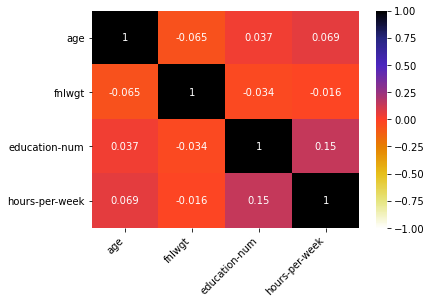

In [405]:
train_data,constant_columns,qconstant_columns,correlated_features =feature_selection_numerical_variables(train_data,0.01,0.75,[])

In [406]:
#  checking for constant columns
constant_columns

['capital-gain', 'capital-loss']

In [407]:
for col in constant_columns:
    continuous_columns.remove(col)

In [408]:
# checking quasi-constant values
qconstant_columns

[]

In [409]:
for col in qconstant_columns:
    continuous_columns.remove(col)

In [410]:
# checking for correlated feature
correlated_features

set()

In [411]:
for col in correlated_features:
    continuous_columns.remove(col)

In [412]:
continuous_columns

['age', 'fnlwgt', 'education-num', 'hours-per-week']

* **Key takeaways:**
* **
    * 2 constant variables removed : capital-gain, capital-loss
    * No correlated column. Correlation < 0.5
    
* **   

In [413]:
# Label encoding for features 
# required before chi2 test
# save the encoders to disk to be fitted on test data
for cf1 in categorical_columns:
    le = preprocessing.LabelEncoder()
    le.fit(train_data[cf1].unique())
    filename = cf1+".sav"
    pickle.dump(le, open(filename, 'wb'))
    train_data[cf1] = le.transform(train_data[cf1])

# Encode the class
le = preprocessing.LabelEncoder()
le.fit(train_data['class'].unique())
filename = "class.sav"
pickle.dump(le, open(filename, 'wb'))
train_data['class'] = le.transform(train_data['class'])

LabelEncoder()

LabelEncoder()

LabelEncoder()

LabelEncoder()

LabelEncoder()

LabelEncoder()

LabelEncoder()

LabelEncoder()

LabelEncoder()

In [414]:
#snippet to calculate the unique values with a categorical columns
df = pd.DataFrame(columns=["Column_Name","Count"])
for cat in categorical_columns:
    unique_value_count = len(train_data[cat].unique())
    df = df.append({'Column_Name': cat, "Count":int(unique_value_count)}, ignore_index=True)
columns_unique_value = np.array(df.Count.value_counts().index)

df

,Column_Name,Count
0,workclass,8
1,education,16
2,marital-status,7
3,occupation,14
4,relationship,6
5,race,5
6,sex,2
7,native-country,41


In [415]:
#snippet to identify the dependent/correlated categorical variables and drop them
columns_to_drop_cat = set()
correlated_columns = dict()
df = df[df['Count']>1]
for column_to_compare in df['Column_Name']:
    if column_to_compare not in columns_to_drop_cat:
        columns_compare_against = df[df['Column_Name'] != column_to_compare]['Column_Name']
        chi_scores = chi2(train_data[columns_compare_against],train_data[column_to_compare])
        # if p-values <= 0.05 then is it highly correlated so must be removed out
        columns_to_be_dropped = [i for i in range(len(columns_compare_against)) if chi_scores[1][i]<=0.05]
        columns_to_drop_array = np.array(columns_compare_against)[columns_to_be_dropped]
        correlated_columns[column_to_compare]=columns_to_drop_array
        columns_to_drop_cat.update(columns_to_drop_array)

In [416]:
correlated_columns

{'workclass': array(['education', 'marital-status', 'occupation', 'relationship',
        'race', 'sex', 'native-country'], dtype=object)}

In [417]:
columns_to_drop_cat

{'education',
 'marital-status',
 'native-country',
 'occupation',
 'race',
 'relationship',
 'sex'}

In [418]:
for col in columns_to_drop_cat:
    categorical_columns.remove(col)

In [419]:
#left  categorical column
categorical_columns

['workclass']

In [420]:
train_data = train_data.drop(columns_to_drop_cat, axis=1)

## Feature Construction

In [421]:
y = train_data['class']
X = train_data.drop('class', axis=1)

In [422]:
# Splitting the dataset into train and test validation
df_test, df_train, y_test, y_train = train_test_split(X, y, test_size = 0.8, random_state=42, stratify = y)
df_test.shape, df_train.shape

((6512, 5), (26049, 5))

In [424]:
# check the proportion of the train vs test
print('Event rate in the training dataset : ',np.mean(y_train))
print()
print('Event rate in the test dataset : ',np.mean(y_test))
print()
print('Event rate in the entire dataset : ',np.mean(y))

Event rate in the training dataset :  0.24081538638719335

Event rate in the test dataset :  0.24078624078624078

Event rate in the entire dataset :  0.2408095574460244


* ratio is kept while splitting to test and train

#### Addressing class imbalance with SMOTE 

* SMOTE : Synthetic Minority OverSampling Technique

In [425]:
df_train.shape, int(sum(y_train)/len(y_train)*100)

((26049, 5), 24)

In [426]:
smote = SMOTE(sampling_strategy = 'minority',k_neighbors = 2,random_state=42)

X_train_smote,y_train_smote=smote.fit_resample(df_train,y_train)

In [427]:
X_train_smote.shape, int(sum(y_train_smote)/len(y_train_smote)*100)

((39552, 5), 50)

#### Normalisation

In [430]:
norm = MinMaxScaler().fit(X_train_smote)
X_train_smote_scaled = norm.transform(X_train_smote)
X_test_scaled = norm.transform(df_test)

## Modeling

#### Neural Network

In [432]:
# custom metrics
def precision(y_true, y_pred): 
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    return precision
def recall(y_true, y_pred): 
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    recall = true_positives / (possible_positives + K.epsilon())
    return recall

In [433]:
def fit_model(data, labels, test_data,test_label, epochs, batch_size):
    
    n_inputs = data.shape[1]
    model    = keras.Sequential()
    model.add(layers.Dense(16, activation ='relu', input_shape =(n_inputs, )))
    model.add(layers.Dropout(0.25))
    model.add(layers.Dense(32,activation = 'relu'))
    model.add(layers.Dropout(0.25))
    model.add(layers.Dense(1,activation ='sigmoid'))
    
    model_file_name = 'MLP_predict_default_case_study.hdf5'
    ckpt = ModelCheckpoint(model_file_name, monitor='val_precision',
                           save_best_only=True, mode='max')
    early = EarlyStopping(monitor="val_recall", mode="max", patience=15)

    model.compile(optimizer = 'adam',
                 loss= 'binary_crossentropy',
                 metrics = [precision,recall])
    
    history = model.fit(data,
                       labels,
                       epochs=epochs,
                       batch_size=batch_size,
                       callbacks=[ckpt, early],
                       verbose = 0,
                       validation_data=(test_data,test_label))
    
    return model

In [434]:
def compute_precisions_thresolds(data, labels, test_data, test_label, epochs, batch_size):
    trained_model = fit_model(data, labels, test_data, test_label, epochs=epochs, batch_size=batch_size)
    y_test_pred   = trained_model.predict(test_data)
    
    P_weighted = [] ; P_macro = [] ; P_micro = [];  R_macro = [] ;R_micro = []; R_weighted = [] ; F1_weighted = [] ; F1_macro = [] ;F1_micro = []; cut_off = [] ; metrics = pd.DataFrame()
    threshold_list = [0.25,0.3,0.4,0.5,0.6,0.7,0.8,0.9,0.95,0.96]
    for thres in threshold_list:
        cut_off.append(thres)
        y_test_pred_new = [1 if el>thres else 0 for el in y_test_pred]
        
        
        prec_weighted         = round(precision_score(test_label, y_test_pred_new, pos_label=1, average='weighted'),2)
        P_weighted.append(prec_weighted)        
        prec_macro            = round(precision_score(test_label, y_test_pred_new, pos_label=1, average='macro'),2)
        P_macro.append(prec_macro)
        prec_micro            = round(precision_score(test_label, y_test_pred_new, pos_label=1, average='micro'),2)
        P_micro.append(prec_micro)
        
        rec_weighted          = round(recall_score(test_label, y_test_pred_new, pos_label=1,average='weighted'),2)
        R_weighted.append(rec_weighted)        
        rec_macro             = round(recall_score(test_label, y_test_pred_new, pos_label=1,average='macro'),2)
        R_macro.append(rec_macro)
        rec_micro             = round(recall_score(test_label, y_test_pred_new, pos_label=1,average='micro'),2)
        R_micro.append(rec_micro)
        
        f1_weighted           = round(f1_score(test_label, y_test_pred_new, average='weighted'),2)
        F1_weighted.append(f1_weighted)        
        f1_macro              = round(f1_score(test_label, y_test_pred_new, average='macro'),2)
        F1_macro.append(f1_macro)
        f1_micro              = round(f1_score(test_label, y_test_pred_new, average='micro'),2)
        F1_micro.append(f1_micro)
        
    metrics = pd.DataFrame({'Threshold' : cut_off, 'Precision weighted' : P_weighted , 'Precision Macro' : P_macro, 'Precision Micro' : P_micro, 'Recall weighted' : R_weighted , 'Recall Macro' : R_macro, 'Recall Micro' : R_micro, 'F1 Score weighted' : F1_weighted,'F1 Score Macro' : F1_macro, 'F1 Score Micro' : F1_micro})
    return metrics.sort_values(by=['Threshold'], ascending=False)

In [435]:
metrics = compute_precisions_thresolds(df_train, y_train, df_test, y_test,epochs=15, batch_size=128)

In [436]:
metrics

,Threshold,Precision weighted,Precision Macro,Precision Micro,Recall weighted,Recall Macro,Recall Micro,F1 Score weighted,F1 Score Macro,F1 Score Micro
9,0.96,0.58,0.38,0.76,0.76,0.5,0.76,0.66,0.43,0.76
8,0.95,0.58,0.38,0.76,0.76,0.5,0.76,0.66,0.43,0.76
7,0.90,0.58,0.38,0.76,0.76,0.5,0.76,0.66,0.43,0.76
6,0.80,0.58,0.38,0.76,0.76,0.5,0.76,0.66,0.43,0.76
5,0.70,0.58,0.38,0.76,0.76,0.5,0.76,0.66,0.43,0.76
4,0.60,0.58,0.38,0.76,0.76,0.5,0.76,0.66,0.43,0.76
3,0.50,0.58,0.38,0.76,0.76,0.5,0.76,0.66,0.43,0.76
2,0.40,0.58,0.38,0.76,0.76,0.5,0.76,0.66,0.43,0.76
1,0.30,0.64,0.51,0.76,0.76,0.5,0.76,0.66,0.44,0.76
0,0.25,0.63,0.50,0.74,0.74,0.5,0.74,0.66,0.46,0.74


In [437]:
smote_metrics = compute_precisions_thresolds(X_train_smote, y_train_smote, df_test, y_test,epochs=15, batch_size=128)

In [438]:
smote_metrics

,Threshold,Precision weighted,Precision Macro,Precision Micro,Recall weighted,Recall Macro,Recall Micro,F1 Score weighted,F1 Score Macro,F1 Score Micro
9,0.96,0.58,0.38,0.76,0.76,0.5,0.76,0.66,0.43,0.76
8,0.95,0.58,0.38,0.76,0.76,0.5,0.76,0.66,0.43,0.76
7,0.90,0.64,0.52,0.75,0.75,0.5,0.75,0.66,0.45,0.75
6,0.80,0.63,0.50,0.65,0.65,0.5,0.65,0.64,0.50,0.65
5,0.70,0.64,0.50,0.42,0.42,0.5,0.42,0.45,0.42,0.42
4,0.60,0.64,0.51,0.30,0.30,0.5,0.30,0.23,0.28,0.30
3,0.50,0.06,0.12,0.24,0.24,0.5,0.24,0.09,0.19,0.24
2,0.40,0.06,0.12,0.24,0.24,0.5,0.24,0.09,0.19,0.24
1,0.30,0.06,0.12,0.24,0.24,0.5,0.24,0.09,0.19,0.24
0,0.25,0.06,0.12,0.24,0.24,0.5,0.24,0.09,0.19,0.24


In [439]:
smote_scaled_metrics = compute_precisions_thresolds(X_train_smote_scaled, y_train_smote, X_test_scaled, y_test,epochs=15, batch_size=128)
smote_scaled_metrics

,Threshold,Precision weighted,Precision Macro,Precision Micro,Recall weighted,Recall Macro,Recall Micro,F1 Score weighted,F1 Score Macro,F1 Score Micro
9,0.96,0.58,0.38,0.76,0.76,0.50,0.76,0.66,0.43,0.76
8,0.95,0.58,0.38,0.76,0.76,0.50,0.76,0.66,0.43,0.76
7,0.90,0.58,0.38,0.76,0.76,0.50,0.76,0.66,0.43,0.76
6,0.80,0.77,0.75,0.78,0.78,0.55,0.78,0.71,0.54,0.78
5,0.70,0.77,0.70,0.79,0.79,0.67,0.79,0.78,0.68,0.79
4,0.60,0.78,0.69,0.76,0.76,0.70,0.76,0.77,0.69,0.76
3,0.50,0.78,0.67,0.72,0.72,0.72,0.72,0.74,0.68,0.72
2,0.40,0.79,0.65,0.65,0.65,0.71,0.65,0.68,0.63,0.65
1,0.30,0.80,0.65,0.60,0.60,0.70,0.60,0.62,0.58,0.60
0,0.25,0.81,0.65,0.56,0.56,0.69,0.56,0.59,0.56,0.56


* **Key takeaways:**
* **
    * Neural Network provides more safety to imbalanced and unscaled data
    
* **   

#### Various ML models

In [440]:
def cal_score(y_test, y_pred): 
    cm              = confusion_matrix(y_test, y_pred)
    prec_scr_weighted  = precision_score(y_test, y_pred, average='weighted')*100
    prec_scr_macro  = precision_score(y_test, y_pred, average='macro')*100
    prec_scr_micro  = precision_score(y_test, y_pred, average='micro')*100
    rec_scr_weighted   = recall_score(y_test ,y_pred, average='weighted')*100
    rec_scr_macro   = recall_score(y_test ,y_pred, average='macro')*100
    rec_scr_micro   = recall_score(y_test ,y_pred, average='micro')*100
    f1_scr_weighted    = f1_score(y_test, y_pred, average='weighted')*100 
    f1_scr_macro    = f1_score(y_test, y_pred, average='macro')*100 
    f1_scr_micro    = f1_score(y_test, y_pred, average='micro')*100 
    return prec_scr_weighted, prec_scr_macro, prec_scr_micro, rec_scr_weighted, rec_scr_macro, rec_scr_micro, f1_scr_weighted, f1_scr_macro, f1_scr_micro, cm

In [441]:
def metrics_calculation(classifier, training_data, testing_data, training_label, testing_label):
    
    result = []
    cols = ['Mean Accuracy', 'Accuracy deviation', 'Precision weighted',  'Precision Macro', 'Precision Micro', 'Recall weighted' ,'Recall Macro','Recall Micro', 'F1 Score weighted' ,'F1 Score Macro', 'F1 Score Micro', 'Confusion Matrix']
    
    crs_val     = cross_val_score(classifier, training_data, training_label, cv=5)
    mean_acc = round(np.mean(crs_val),3)
    std_acc  = round(np.std(crs_val),3)
    classifier.fit(training_data, training_label)
    predictions = classifier.predict(testing_data)
    prec_scr_weighted, prec_scr_macro, prec_scr_micro, rec_scr_weighted, rec_scr_macro, rec_scr_micro, f1_scr_weighted, f1_scr_macro, f1_scr_micro, cm = cal_score(testing_label, predictions)
    result.extend([mean_acc,std_acc, prec_scr_weighted, prec_scr_macro, prec_scr_micro, rec_scr_weighted, rec_scr_macro, rec_scr_micro, f1_scr_weighted, f1_scr_macro, f1_scr_micro, cm])
    series_result = pd.Series(data=result, index=cols)
    
    return series_result


In [442]:
clf_dict = {
    'Random Forest': RandomForestClassifier(random_state=42),
    'XGBoost': XGBClassifier(random_state=42),
    'Logistic Regression' : LogisticRegression(random_state=42),
    'Light GBM' : LGBMClassifier(random_state=42)
}

In [443]:
frame = {}
for key in clf_dict:

    classifier_result = metrics_calculation(clf_dict[key], df_train, df_test, y_train, y_test)
    frame[key]    = classifier_result
        
original_df = pd.DataFrame(frame)
original_df

[15:16:01] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[15:16:04] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[15:16:06] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[15:16:08] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old be

,Random Forest,XGBoost,Logistic Regression,Light GBM
Mean Accuracy,0.772,0.799,0.759,0.799
Accuracy deviation,0.004,0.005,0,0.004
Precision weighted,74.9337,77.9301,57.6406,78.258
Precision Macro,66.7529,72.4147,37.9607,73.081
Precision Micro,76.3053,79.6683,75.9214,79.9754
Recall weighted,76.3053,79.6683,75.9214,79.9754
Recall Macro,64.5151,66.4033,50,66.5185
Recall Micro,76.3053,79.6683,75.9214,79.9754
F1 Score weighted,75.4597,78.1104,65.5299,78.3355
F1 Score Macro,65.373,68.2244,43.1564,68.449


In [444]:
frame = {}
for key in clf_dict:

    classifier_result = metrics_calculation(clf_dict[key], X_train_smote_scaled, X_test_scaled, y_train_smote, y_test)
    frame[key]    = classifier_result
        
scaled_smote_df = pd.DataFrame(frame)
scaled_smote_df

[15:16:55] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[15:17:01] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[15:17:10] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[15:17:16] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old be

,Random Forest,XGBoost,Logistic Regression,Light GBM
Mean Accuracy,0.792,0.797,0.724,0.788
Accuracy deviation,0.047,0.051,0.002,0.046
Precision weighted,74.9446,77.8204,78.8177,78.4945
Precision Macro,64.2689,68.013,66.9949,68.4489
Precision Micro,71.9595,75.3686,71.1763,75.3225
Recall weighted,71.9595,75.3686,71.1763,75.3225
Recall Macro,66.7918,70.9096,72.46,72.0551
Recall Micro,71.9595,75.3686,71.1763,75.3225
F1 Score weighted,73.0908,76.2802,73.1087,76.4119
F1 Score Macro,64.9989,68.9868,67.1291,69.5113


In [445]:
frame = {}
for key in clf_dict:

    classifier_result = metrics_calculation(clf_dict[key], X_train_smote, df_test, y_train_smote, y_test)
    frame[key]    = classifier_result
        
smote_df = pd.DataFrame(frame)
smote_df

[15:18:13] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[15:18:16] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[15:18:20] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[15:18:25] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old be

,Random Forest,XGBoost,Logistic Regression,Light GBM
Mean Accuracy,0.792,0.797,0.586,0.788
Accuracy deviation,0.046,0.051,0.02,0.047
Precision weighted,74.9855,77.8204,70.4551,78.4945
Precision Macro,64.3451,68.013,56.0822,68.4489
Precision Micro,72.067,75.3686,47.8655,75.3225
Recall weighted,72.067,75.3686,47.8655,75.3225
Recall Macro,66.8409,70.9096,57.5871,72.0551
Recall Micro,72.067,75.3686,47.8655,75.3225
F1 Score weighted,73.1776,76.2802,50.2531,76.4119
F1 Score Macro,65.0792,68.9868,47.2148,69.5113


In [446]:
models = [
    {
    'label': 'Random Forest',
    'model': RandomForestClassifier(random_state=42)
    },
    {
    'label' : 'XGBoost',
    'model' : XGBClassifier(random_state=42)
    },
    {
    'label' : 'Logistic Regression',
    'model' : LogisticRegression(random_state=42)
    },
    {
    'label' : 'Light GBM',
    'model' : LGBMClassifier(random_state=42)
    }
]

In [447]:
def plot_multiplt_rocauc(models,train_X, train_y ,dev_X, dev_y):
    
    for m in models:
        model = m['model']   
        model.fit(train_X, train_y)
        y_pred = model.predict(dev_X)
        pred   = model.predict_proba(dev_X)
        pred_new = [i[1] for i in pred]
        fpr, tpr, thresholds = roc_curve(dev_y, pred_new)
        roc_auc = auc(fpr, tpr)
        
        plt.plot(fpr, tpr, label='%s ROC (area = %0.2f)' % (m['label'], roc_auc))
    plt.plot([0, 1], [0, 1],'r--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('1-Specificity(False Positive Rate)')
    plt.ylabel('Sensitivity(True Positive Rate)')
    plt.title('Receiver Operating Characteristic')
    plt.legend(loc="lower right")
    plt.show()   # Display
    
    return 

[15:18:53] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


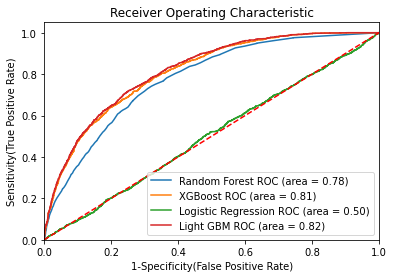

In [448]:
plot_multiplt_rocauc(models,df_train,y_train, df_test, y_test)

[15:19:03] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


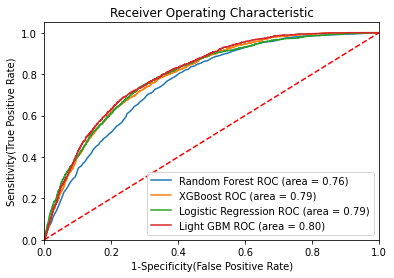

In [449]:
#ploting smoted and scaled data

plot_multiplt_rocauc(models,X_train_smote_scaled,y_train_smote, X_test_scaled, y_test)

[15:19:17] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


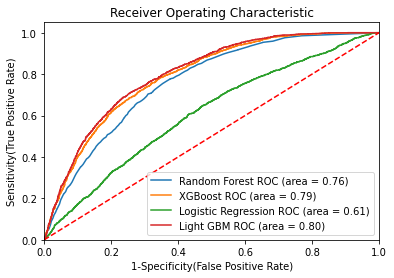

In [450]:
#ploting smoted only
plot_multiplt_rocauc(models,X_train_smote,y_train_smote, df_test, y_test)

* **Key takeaways:**
* **
    * Logistic Regression requires scaling and class balancing
    * Tree-based models are safe from imbalanced/unscaled dataset   
    
* **   

In [451]:
def plot_feature_importances(model, model_name,  features):
    print(model_name)
    plt.figure(figsize=(8,6))
    n_features = len(features)
    plt.barh(range(n_features), model.feature_importances_, align='center')
    plt.yticks(np.arange(n_features), features)
    plt.xlabel("Feature importance")
    plt.ylabel("Feature")    
    plt.ylim(-1, n_features)
    plt.show()

Random Forest


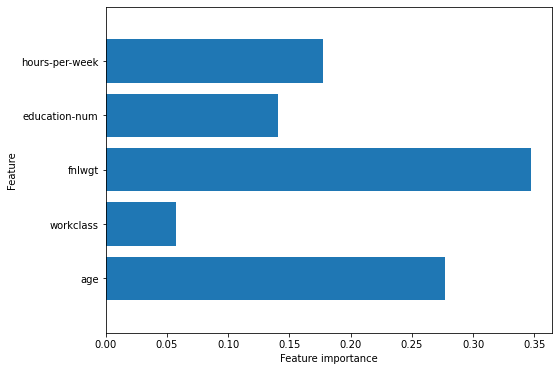

XGBoost


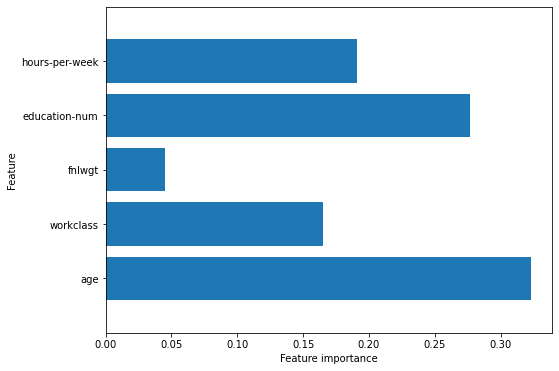

Light GBM


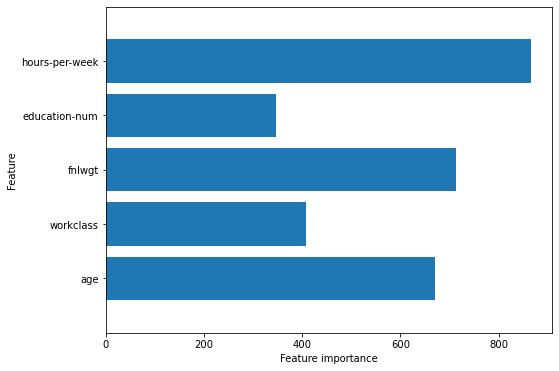

In [452]:
features = df_train.columns

for key in clf_dict.keys():
    if key =='Logistic Regression':
        continue
    else:        
        plot_feature_importances(clf_dict[key], key, features)

## Feature Importance

#### SHAP (SHapley Additive exPlanations)

** SHAP is used to assess the importance of each feature in the overall test result 

RandomForestClassifier(random_state=42)

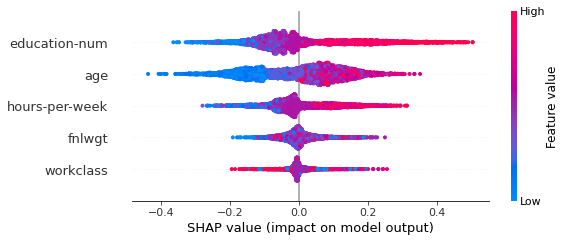

In [453]:
X_importance = df_test

model = RandomForestClassifier(random_state=42)   
model.fit(df_train,y_train)

# Explain model predictions using shap library:
explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(X_importance)
# Plot summary_plot
shap.summary_plot(shap_values[1], X_importance)

* **Key takeaways:**
* **
    * Order of importance from bottom to top i.e. education-num is the most impactful to the classification
    * The more education is, the more is the chance to get "1"
    * The higher the workclass is, the more is the chance to get "0"
    
* **   

#### LIME (Local Interpretable Model agnostic Explanations)

** LIME is useful to analyse the influence of each feature in the outcome of one single test

In [454]:
# creating the explainer function
explainer = LimeTabularExplainer(df_test.values, mode="classification", feature_names=df_test.columns)

In [455]:
predict_model_rf = lambda x: model.predict_proba(x).astype(float)

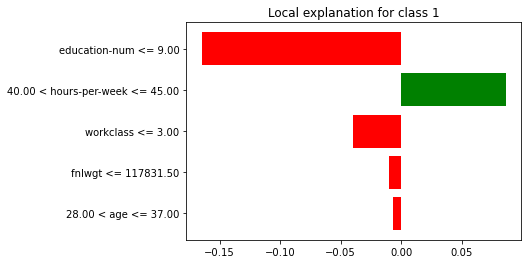

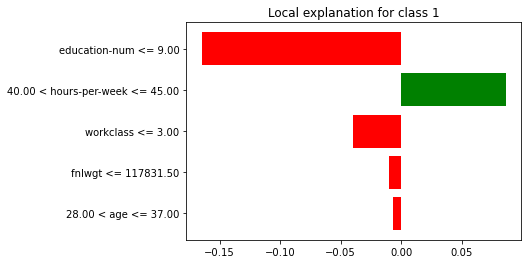

In [456]:
exp = explainer.explain_instance(df_test.iloc[2], predict_model_rf)
exp.as_pyplot_figure()

* **Key takeaways:**
* **
    * Order of importance from bottom to top i.e. education-num is the most impactful to the classification
    * Education-num =9 is the most impactful  on the classification "0", followed by workclass = 3
    * Hours-per-week is trying to steer to "1" but not enough strong to influence the classification result
    
* **   